3G DATA:
    year  coverage_3G
7   2014         50.0
8   2015         69.0
9   2016         78.0
10  2017         85.0
11  2018         86.0
12  2019         93.3
13  2020         94.0
14  2021         95.0
15  2022         98.0
16  2023         98.0
17  2024         98.0
(11, 2)

MERGED MODEL DATA:
    year  coverage_3G  mobile_subs_per_100  population_total
0   2014         50.0              73.0327        46051440.0
1   2015         69.0              80.0958        47088526.0
2   2016         78.0              80.9772        48139687.0
3   2017         85.0              87.0265        49197766.0
4   2018         86.0              98.5945        50207107.0
5   2019         93.3             106.5480        51202827.0
6   2020         94.0             117.6030        52217334.0
7   2021         95.0             122.2980        53219166.0
8   2022         98.0             121.1690        54252461.0
9   2023         98.0             120.6120        55339003.0
10  2024         98.0       

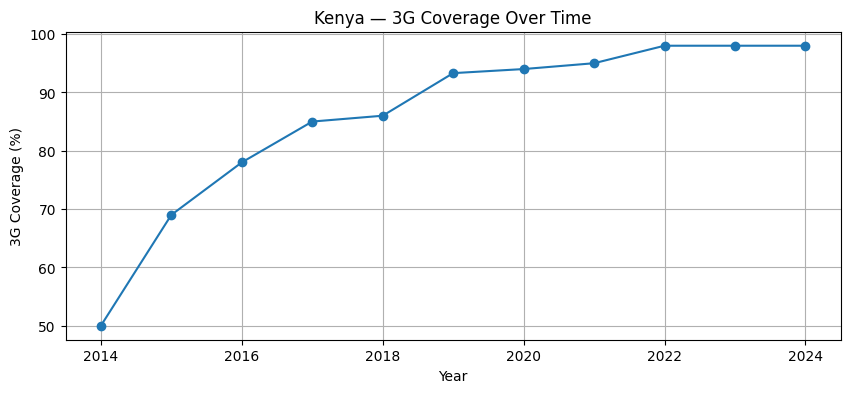

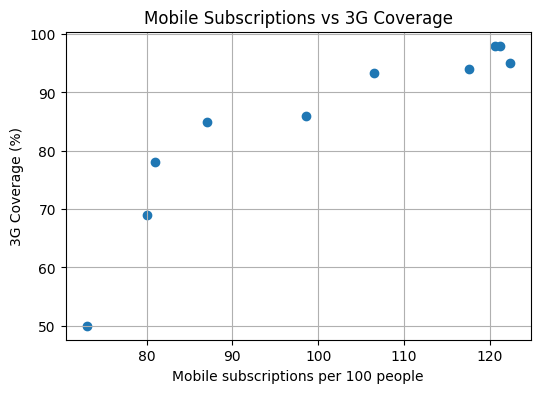

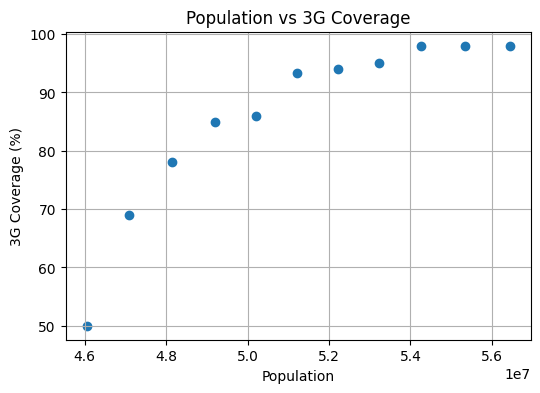


Your data is now clean and ready for regression modelling.
R² Score: 0.8934096666119341
RMSE:, 4.1491307899128405

Coefficients:
mobile_subs_per_100    0.082011
population_total       0.000004
dtype: float64
Intercept: -131.03551609490182


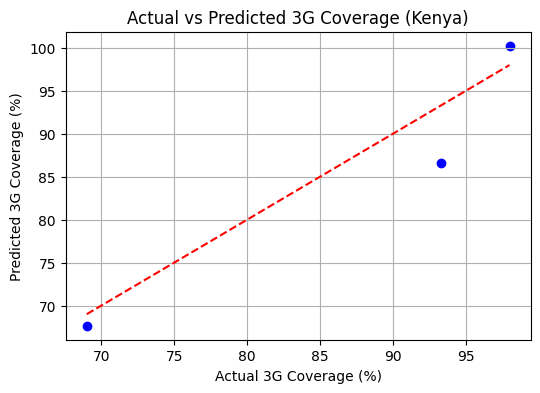

Next is future predictions 2025-2030

Future predictor estimates:
   year  mobile_subs_per_100  population_total
0  2025           141.056792      5.735649e+07
1  2026           147.250811      5.838187e+07
2  2027           153.444830      5.940725e+07
3  2028           159.638848      6.043263e+07
4  2029           165.832867      6.145800e+07
5  2030           172.026886      6.248338e+07

Future 3G Coverage Predictions (2025–2030):
   year  predicted_3G
0  2025    114.546100
1  2026    119.237602
2  2027    123.929103
3  2028    128.620605
4  2029    133.312106
5  2030    138.003608


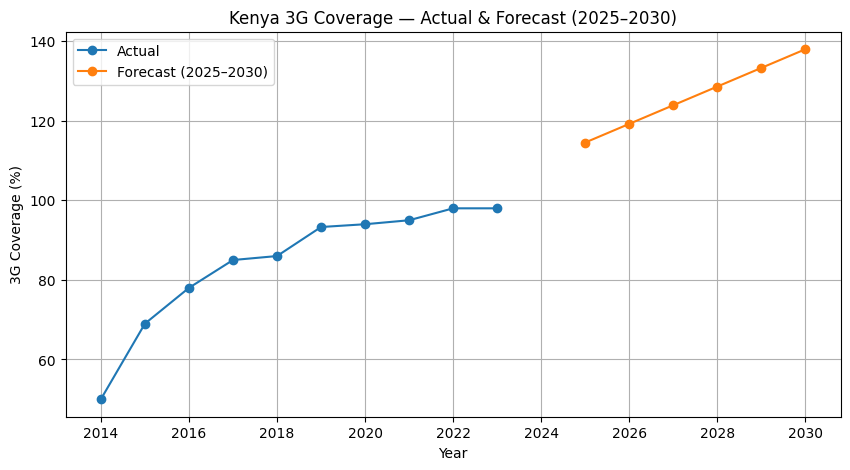

In [1]:
from sklearn.metrics import root_mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt

# Load 3G Coverage dataset

df_3g_raw = pd.read_csv("WB-Dataset/ITU_DH_POP_COV_3G_WIDEF.csv")

# Filter Kenya data
df_3g_raw = df_3g_raw[df_3g_raw["REF_AREA_LABEL"] == "Kenya"]

# Extract year columns (your file uses year-only column names)
year_cols = [c for c in df_3g_raw.columns if c.startswith("20")]

# Convert wide → long
df_3g = df_3g_raw[year_cols].transpose().reset_index()
df_3g.columns = ["variable", "coverage_3G"]

# Extract year from var
df_3g["year"] = df_3g["variable"].str.extract(r"(\d{4})").astype(int)

# Final clean dataset
df_3g = df_3g[["year", "coverage_3G"]].sort_values("year")
df_3g = df_3g.dropna()

print("World bank 3G Coverage Data:")
print(df_3g)
print(df_3g.shape)

# Predictor Function for WorldBank Dataset.

def load_wb_dataset(path, value_name):
    df = pd.read_csv(path, skiprows=4) 

    # Keep only Kenya
    df = df[df["Country Name"] == "Kenya"]

    # Keep only year columns
    year_cols = [c for c in df.columns if c.isdigit()]

    # Melt wide → long
    df_long = df.melt(id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
                      value_vars=year_cols,
                      var_name="year", value_name=value_name)

    df_long["year"] = df_long["year"].astype(int)

    # Keep only year + value
    df_long = df_long[["year", value_name]]

    # Drop missing values
    df_long = df_long.dropna()

    return df_long

# Filter Predictors years (2007-2024)

years_available = df_3g["year"].unique()

population = load_wb_dataset("WB-Dataset/API_SP.POP.TOTL_DS2_en_csv_v2_69.csv", "population_total")
population = population[population["year"].isin(years_available)]

mobile = load_wb_dataset("WB-Dataset/API_IT.CEL.SETS.P2_DS2_en_csv_v2_3030.csv", "mobile_subs_per_100")
mobile = mobile[mobile["year"].isin(years_available)]

# OPTIONAL FUTURE PREDICTORS:
# internet = load_wb_dataset("Data/API_IT.NET.USER.ZS_DS2_en_csv_v2_3030.csv", "internet_users_pct")
# internet = internet[internet["year"].isin(years_available)]



# MERGE and No duplicate years


# Merge one-to-one
df_model = (
    df_3g
    .merge(mobile, on="year", how="left")
    .merge(population, on="year", how="left")
    # .merge(internet, on="year", how="left")   # Uncomment if included
)

print("\nMERGED MODEL DATA:")
print(df_model)
print(df_model.shape)


# Visualize 3G Coverage Over Time
plt.figure(figsize=(10,4))
plt.plot(df_model["year"], df_model["coverage_3G"], marker="o")
plt.title("Kenya — 3G Coverage Over Time")
plt.xlabel("Year")
plt.ylabel("3G Coverage (%)")
plt.grid(True)
plt.show()

# Predictor vs 3G scatter plots

# Mobile Subscriptions
plt.figure(figsize=(6,4))
plt.scatter(df_model["mobile_subs_per_100"], df_model["coverage_3G"])
plt.xlabel("Mobile subscriptions per 100 people")
plt.ylabel("3G Coverage (%)")
plt.title("Mobile Subscriptions vs 3G Coverage")
plt.grid(True)
plt.show()

# Population
plt.figure(figsize=(6,4))
plt.scatter(df_model["population_total"], df_model["coverage_3G"])
plt.xlabel("Population")
plt.ylabel("3G Coverage (%)")
plt.title("Population vs 3G Coverage")
plt.grid(True)
plt.show()


# READY FOR REGRESSION


print("\nWB data is now clean and ready for regression modelling.")


# Model training for regression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Clean the data for Modeling

df_reg = df_model.dropna()

X = df_reg[['mobile_subs_per_100', 'population_total']]
y = df_reg['coverage_3G']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


# TRAIN MODEL

model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate Model

y_pred = model.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
rmse = root_mean_squared_error(y_test, y_pred)
#mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE:, {rmse}")
#print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

print("\nCoefficients:")
print(pd.Series(model.coef_, index=X.columns))
print("Intercept:", model.intercept_)

# VISUALIZE PREDICTED VS ACTUAL

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual 3G Coverage (%)")
plt.ylabel("Predicted 3G Coverage (%)")
plt.title("Actual vs Predicted 3G Coverage (Kenya)")
plt.grid(True)
plt.show()

# ---
#Future Prediction 2025 - 2030
#---
print(f"Next is future predictions 2025-2030\n")

# ------------------------------------------
# 1. Fit trend model for future predictors
# ------------------------------------------
from sklearn.linear_model import LinearRegression
import numpy as np

# MOBILE SUBSCRIPTIONS TREND
mobile_trend = LinearRegression()
mobile_trend.fit(df_reg[['year']], df_reg['mobile_subs_per_100'])

# POPULATION TREND
pop_trend = LinearRegression()
pop_trend.fit(df_reg[['year']], df_reg['population_total'])

# ------------------------------------------
# 2. Generate future years
# ------------------------------------------
future_years = np.arange(2025, 2031)
future_df = pd.DataFrame({'year': future_years})

# Predict future values
future_df['mobile_subs_per_100'] = mobile_trend.predict(future_df[['year']])
future_df['population_total'] = pop_trend.predict(future_df[['year']])

print("Future predictor estimates:")
print(future_df)

## Linear regression for the above prediction

# ------------------------------------------
# 3. Predict future 3G coverage
# ------------------------------------------
future_X = future_df[['mobile_subs_per_100', 'population_total']]
future_df['predicted_3G'] = model.predict(future_X)

print("\nFuture 3G Coverage Predictions (2025–2030):")
print(future_df[['year', 'predicted_3G']])

#---
#Visualize the above forecast
#---
plt.figure(figsize=(10,5))

# Actual historical
plt.plot(df_reg['year'], df_reg['coverage_3G'], marker='o', label='Actual')

# Forecast
plt.plot(future_df['year'], future_df['predicted_3G'], marker='o', label='Forecast (2025–2030)')

plt.title("Kenya 3G Coverage — Actual & Forecast (2025–2030)")
plt.xlabel("Year")
plt.ylabel("3G Coverage (%)")
plt.grid(True)
plt.legend()
plt.show()

